# A Primer on Gibbs Sampling :   Hidden Markov Model a Bayesian View


**Most influential algorithms in 21st century**

* Metropolis Algorithm for Monte Carlo
* Simplex Method for Linear Programming
* Krylov Subspace Iteration Methods
* The Decompositional Approach to Matrix Computations
* The Fortran Optimizing Compiler
* QR Algorithm for Computing Eigenvalues
* Quicksort Algorithm for Sorting
* Fast Fourier Transform
* Integer Relation Detection
* Fast Multipole Method

Hidden Markov Model (HMM) is a statistical Markov model in which the system being modeled is assumed to be a Markov process with unobserved states.

I chose this as an example of a Latent Space Model.

By definition, a latent space model has observed data $Y$ and latent variables $X$ and parameters $\theta$. 

In a Bayesian world, distribution of the data is constant, the parameters vary. Thus we want to find out the 

In [22]:
import pymc3 as pm
import theano.tensor as tt
import theano.tensor.slinalg as sla
import theano.tensor.nlinalg as nla
import matplotlib.pyplot as plt
import numpy as np
from collections import OrderedDict
from hmmlearn import hmm
import pandas as pd
%matplotlib inline

In [23]:
pi=OrderedDict()
a=OrderedDict()
mean=OrderedDict()
cov=OrderedDict()
model=OrderedDict()
power=OrderedDict()
state=OrderedDict()

In [24]:
pi['ref']=np.array([0.5,0.5])
a['ref']=np.array([[0.95,0.05],[0.05,0.95]])
mean['ref']=np.array([[0],[120]])
cov['ref']=np.tile(np.identity(1), (2, 1, 1))
model['ref']=hmm.GaussianHMM(pi['ref'].size, "full", pi['ref'],a['ref'])
model['ref'].means_ = mean['ref']
model['ref'].covars_ = cov['ref']
model['ref'].transmat_ = a['ref']
model['ref'].startprob_ = pi['ref']

In [25]:
cov['ref'].reshape(2,)

array([1., 1.])

In [26]:
import warnings
warnings.filterwarnings('ignore')
sample_size = 500
power['ref'], state['ref'] = model['ref'].sample(sample_size)


In [27]:
states = ('OFF','ON' )
end_state = 'E'
  
start_probability = {'OFF': 0.5, 'ON': 0.5}
 
transition_probability = {
   'OFF' : { 'OFF': 0.95, 'ON': 0.05,'E': 0.01},
   'ON' : { 'OFF': 0.05,'ON': 0.95, 'E': 0.01},
   
   }
 
mu = { 'OFF': 0.5, 'ON': 120} 
sigma = { 'OFF': 1, 'ON': 1} 
NStates = 2




start_prob = start_probability
trans_prob = transition_probability
 

In [28]:

observations = power['ref'] 
observations.shape

(500, 1)

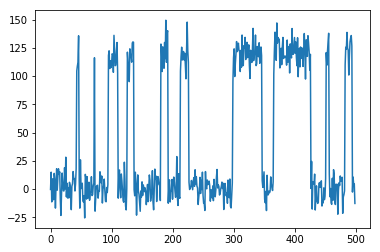

In [29]:
observations = observations +   np.random.normal(0,10, (sample_size,1))


plt.plot(observations)

In [30]:
def compute_emission(obs , mu , sigma):
    step1 = -(obs - mu)**2/(2*sigma)
    step2 = np.sqrt(2*np.pi*sigma**2)
    return np.exp(step1)/step2


def forward(observations, states, start_prob, trans_prob, mu , sigma, end_st):
    # forward part of the algorithm
    fwd = []
    f_prev = {}
    for i, observation_i in enumerate(observations):

        f_curr = {}
        norm = 0
        for st in states:
            if i == 0:
                # base case for the forward part
                prev_f_sum = np.array(0) if start_prob[st] ==0 else np.log(start_prob[st]) 
            else:
                prev_f_sum = sum(f_prev[k] if trans_prob[k][st] == 0 else f_prev[k] + np.log(trans_prob[k][st]) for k in states)
            # print(prev_f_sum    )
            f_curr[st] = prev_f_sum if compute_emission(observation_i, mu[st] , sigma[st])==0 else np.log(compute_emission(  observation_i, mu[st] , sigma[st])) + prev_f_sum 
            norm = norm + np.exp(f_curr[st])
        for st in states:    
            f_curr[st] =  np.log(np.exp(f_curr[st]) / norm)
        fwd.append( f_curr) 
        
        f_prev = f_curr

    p_fwd = sum( f_curr[k] if  trans_prob[k][end_st] == 0  else f_curr[k]  + np.log(trans_prob[k][end_st]) for k in states)
    return np.exp(pd.DataFrame.from_dict(fwd ).astype('float64')) 

In [31]:
mu = { 'OFF': 0, 'ON': 150} 
sigma = { 'OFF': 5, 'ON': 5} 
transition_probability = {
   'OFF' : { 'OFF': 0.7, 'ON': 0.3,'E': 0.01},
   'ON' : { 'OFF': 0.3,'ON': 0.7, 'E': 0.01},   
   }

α = forward(observations,  states,  start_probability, transition_probability, mu,sigma,  end_state)

In [32]:
A = np.fliplr(α.values)
t = α.shape[0]-1


In [33]:
size = 10

sample = np.zeros((size, sample_size)).astype(int)
p = np.array([[0.7,0.3],[0.3,0.7]])


for i in range(size):
    for t in range(α.shape[0]-1,-1,-1):
        if t == α.shape[0] - 1:
            sample[i,t] =   np.random.choice(2, 1, p= A[t,]).astype(int) 
        else:
            Prob1 =  A[t][0]* p[0][sample[i,t+1]]
            Prob2 = A[t][1]*p[1][sample[i,t+1]]

            P1 = Prob1/(Prob1 + Prob2)
            P2 = Prob2/(Prob1 + Prob2)
            sample[i,t] =  np.random.choice(2, 1, p = np.array([P1, P2])).astype(int)
 

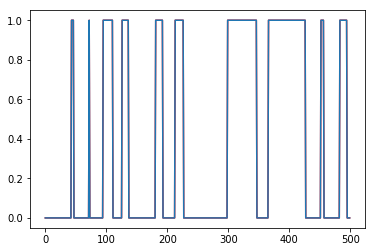

In [34]:
 
plt.plot(  np.mod(state['ref'] ,2), c = 'r')
 
samples = np.round(sample.mean(axis = 0)).astype(int)
plt.plot(samples)

# μ Sampling

\begin{align}
μ_i   &=  \mathbb N (  ξ , κ^{-1}) \\
\xi &= \frac{min (y_k) + max (y_k)}{2} \\
\kappa &= \frac{1}{R^2}, R =max (y_k) -  min (y_k) \\
P(\mu_i | X, Y, \sigma)  &= \mathbb N ( \frac{\sum_{i}S_i + \kappa\xi\sigma^2}{\sum_{i}n_i + \kappa\sigma^2} , ) 
\end{align}

In [35]:
μ = np.zeros(NStates,)
ξ = (np.max(observations) + np.min(observations))/2
R = (np.max(observations) - np.min(observations))
κ = 1/R**2

σ = np.array([0.5, 1])

for i in range(NStates):
    
    S = np.sum(power['ref'][samples == i])
    n = np.sum([samples == i])
    
    mean = (S + κ * ξ * σ[i]**2) / (n + κ * σ[i]**2)
    sd = σ[i]**2/  (n + κ * σ[i]**2)
    μ[i] = np.random.normal(loc=mean, scale=sd, size = 1) 
mu['OFF'] = μ[0]
mu['ON'] = μ[1]

mu

{'OFF': 0.013461495896134512, 'ON': 119.98053821933861}

# Sampling σ

In [36]:
β = np.random.gamma(0.2 , 10/R**2)
β

1.6868242978101088e-05

In [37]:
n = observations.reshape(-1,1).shape[0]


α = 2

# np.sum(observations - μ[samples])

τ = np.random.gamma(α + n/2, β + 1/2 * np.sum((observations.reshape(-1,1) -  μ[samples].reshape(-1,1))**2))

σ = np.sqrt(1/τ)

# Sampling β

In [38]:
β = np.random.gamma(0.2 + α, 10/R**2 + τ)

β

8591079.55989715

# Sampling Transition Probabilities 

In [58]:
def count(samples):
    count_mat = np.zeros((2,2))
    for i in range(0,sample_size-1):
 
            
            count_mat[samples[i]][samples[i+1]] += 1
                
    return count_mat

count_mat = count(samples)
            
transition = np.zeros((2,2))
transition[0] = np.random.dirichlet((count_mat[0][0] + 1.0, count_mat[0][1]  + 1.0), 1).reshape(2,)
transition[1] = np.random.dirichlet((count_mat[1][0] + 1.0, count_mat[1][1]  + 1.0), 1).reshape(2,)
#start

array([[0.95418958, 0.04581042],
       [0.07150116, 0.92849884]])

# Sampling Start Probabilities

In [61]:
start = np.random.dirichlet( ( (samples[0] == 0) + 1 , (samples[0] == 1) + 1) , 1).reshape(2,)


start_probability['OFF'] = start[0]
start_probability['ON'] = start[1]

In [62]:
start

array([0.20347367, 0.79652633])

# Finish the code to iterate the process